In [1]:
import sys

sys.path.append("../")

## Running the simulations

(All the simulations should be run using scripts) \
This notebook starts by reading the data

In [2]:
# import os
# import scripts


# leaks_path = "../data/leaks"
# reports_path = "../data/reports"
# network_path = "../data/Hanoi.inp"

# os.environ["EPANET_HOME"] = "../EPANET/build/bin/runepanet"

# scripts.prepare_files(network_path, leaks_path)
# scripts.run_simulations(leaks_path, reports_path)

## Reading the reports

In [3]:
from annealing.utils import read_pressures

report_dir_path = "../MISS_OUTPUT/"
pressures, leakage_node, ts = read_pressures(report_dir_path)

## Reading the graph

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Kleszczow.inp loaded successfully.



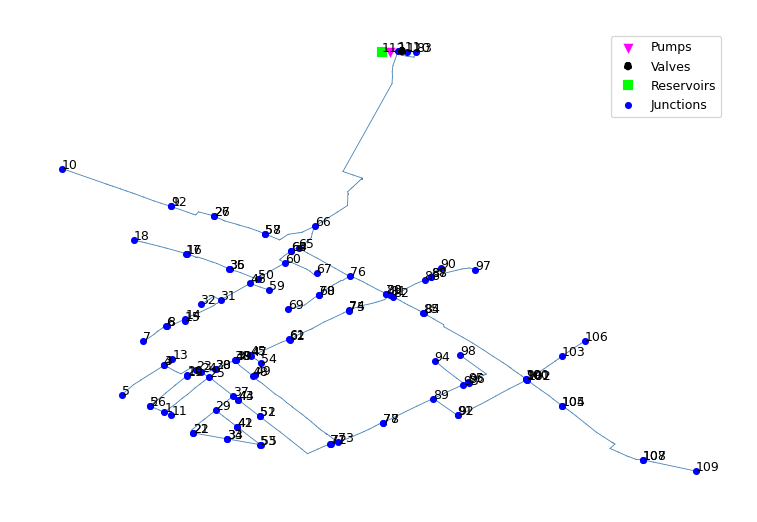

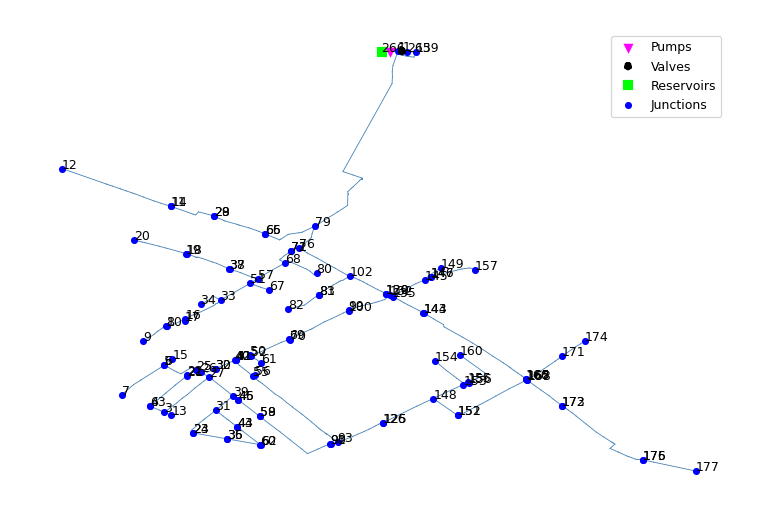

In [4]:
from epyt import epanet
from annealing.graph_utils import Network

input_file = "../data/Kleszczow.inp"
G = epanet(input_file)

network = Network(G)
network.plot_with_indexes()
network.plot_with_ids()

## Simulated Annealing

Data split, training dataset is used to fit the KNN-classifier. The prediction on the test dataset is used in the evaluation function.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

leakage_node_mapped = network.map_node_ids(leakage_node)
train_pressures, test_pressures, train_labels, test_labels = train_test_split(pressures, leakage_node_mapped, test_size=0.5, stratify=leakage_node)

Function for the evaluation of the candidate solution

In [6]:
from annealing.algorithm import random_solution, evaluate_solution, generate_neighbor
import numpy as np

vertices = np.array(network.node_indexes)
solution = random_solution(vertices, 4)

print(solution)
print(evaluate_solution(solution, network, train_pressures, train_labels, test_pressures, test_labels))
print(generate_neighbor(solution, network))

[11 95  7 21]
0.8192486583184259
[11 94  7 21]


### Annealing

 20%|█▉        | 99/500 [00:30<02:04,  3.22it/s]

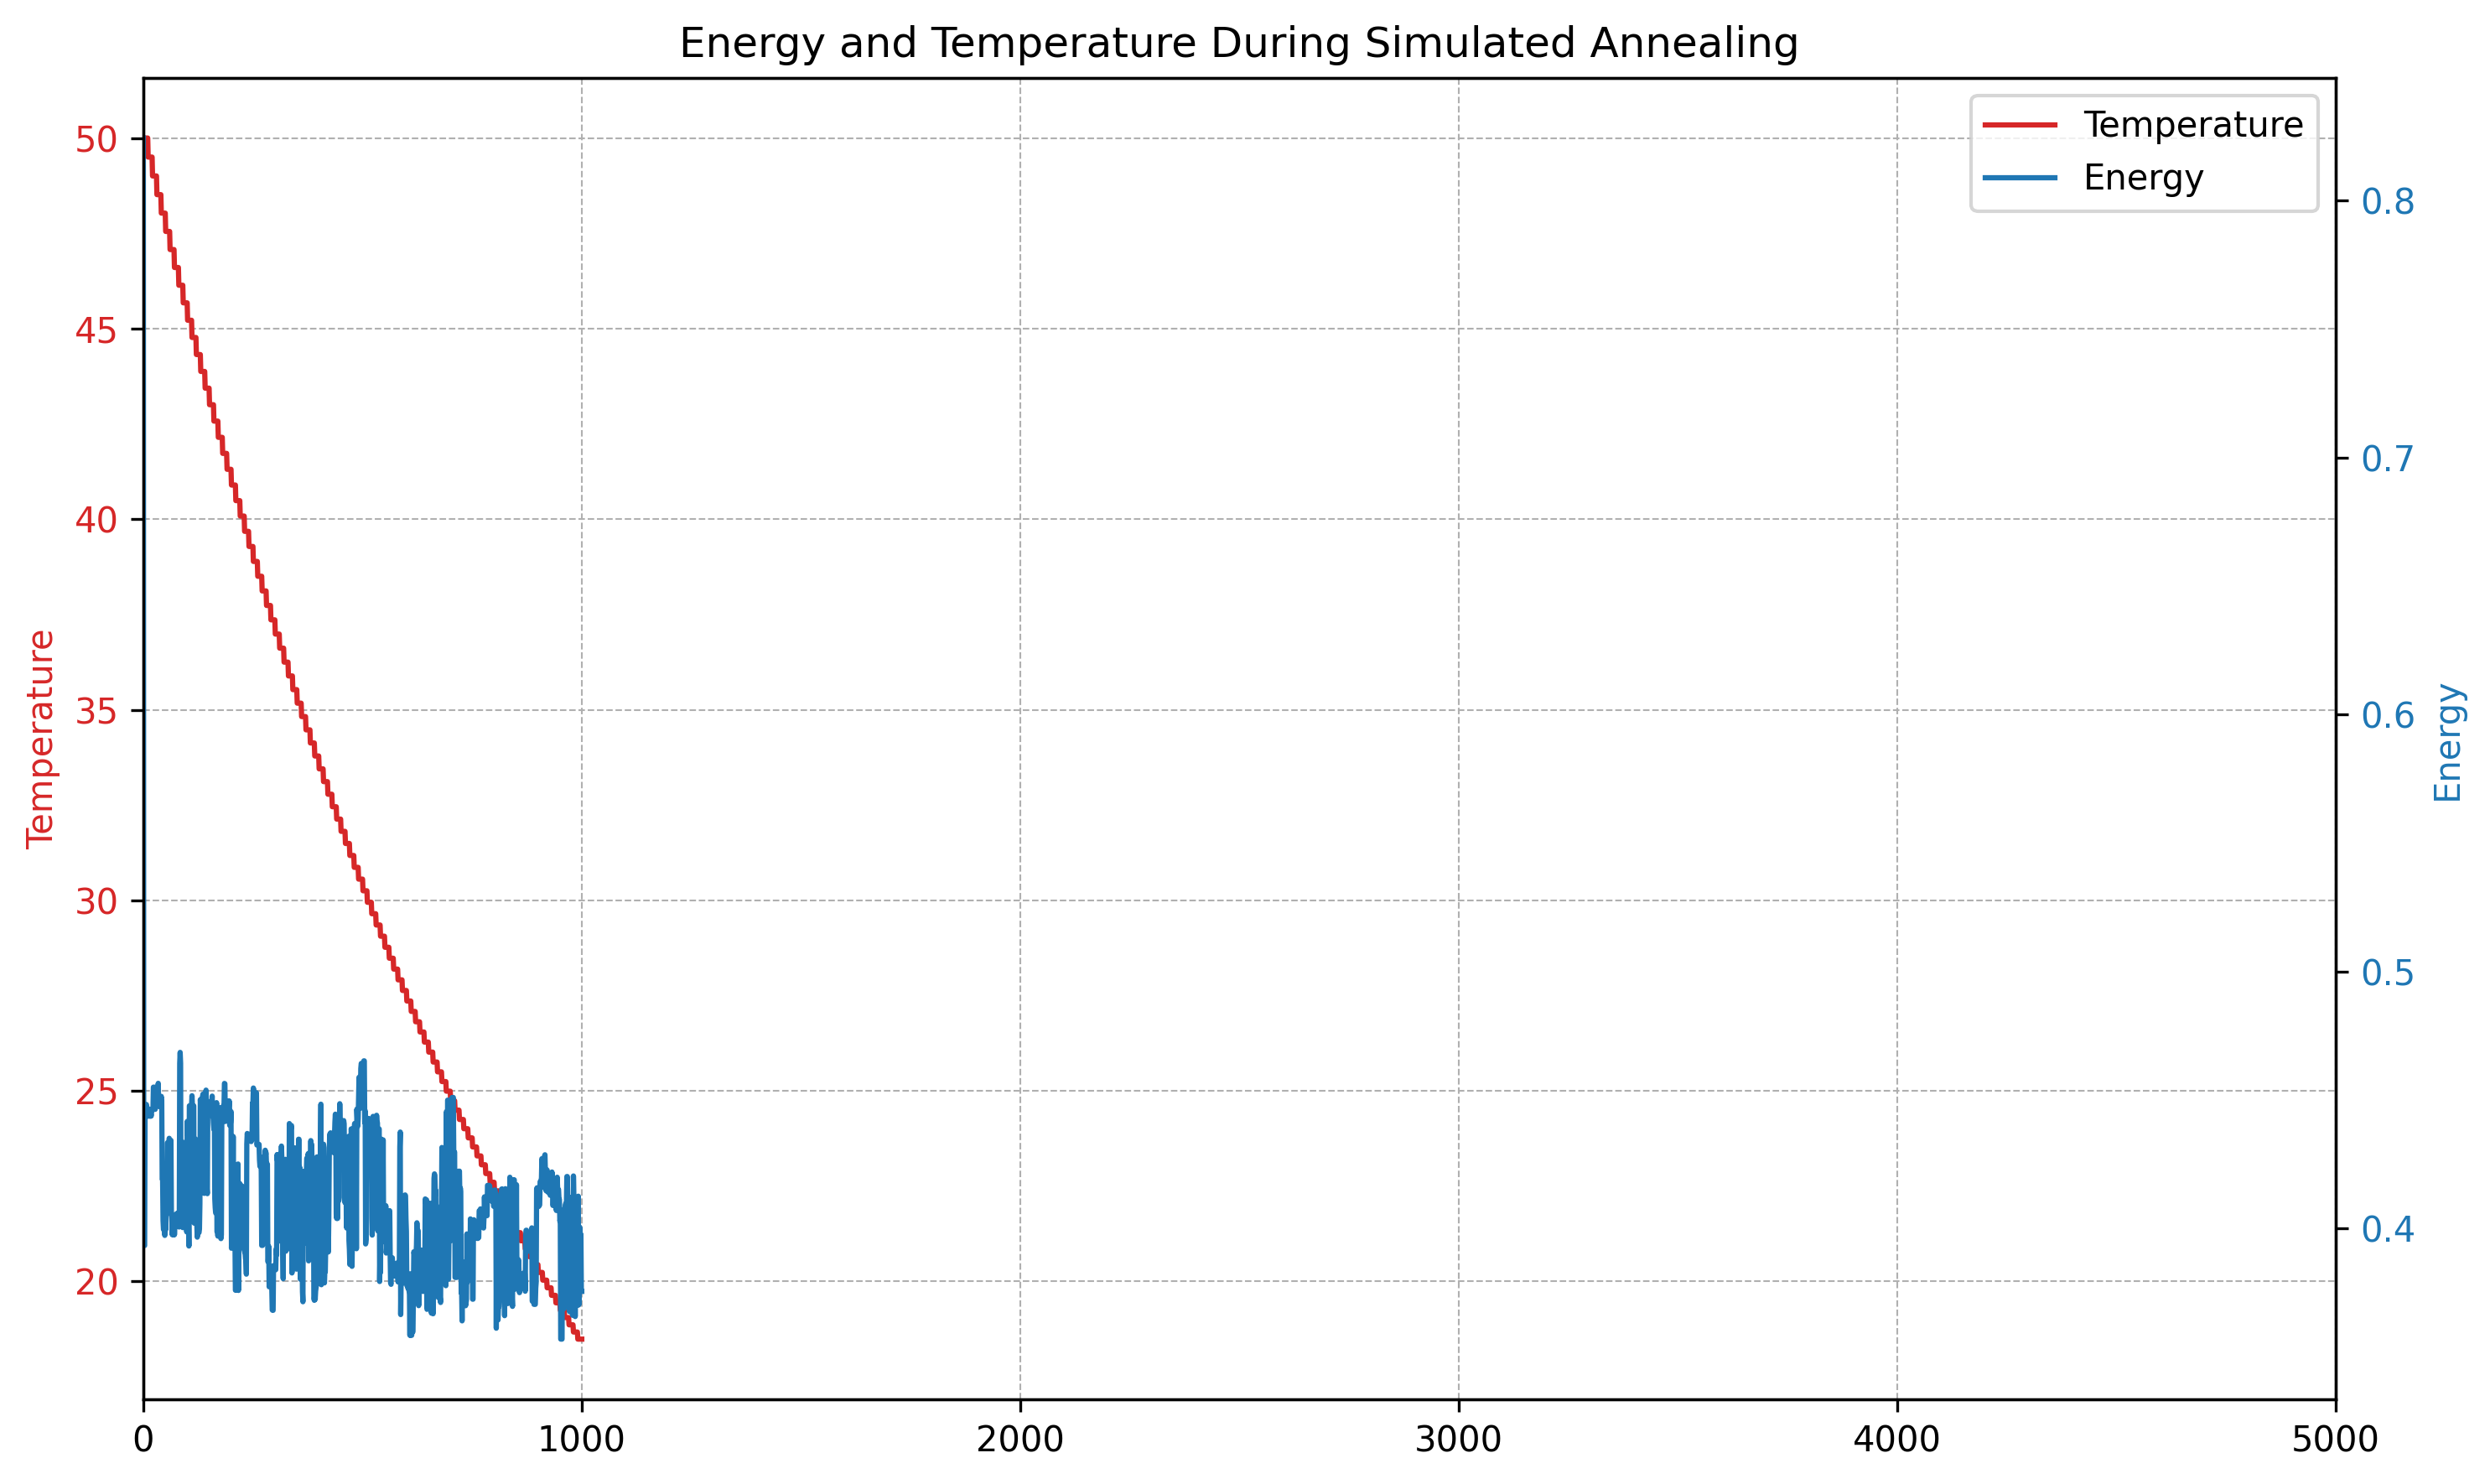

 40%|███▉      | 199/500 [01:01<01:34,  3.20it/s]

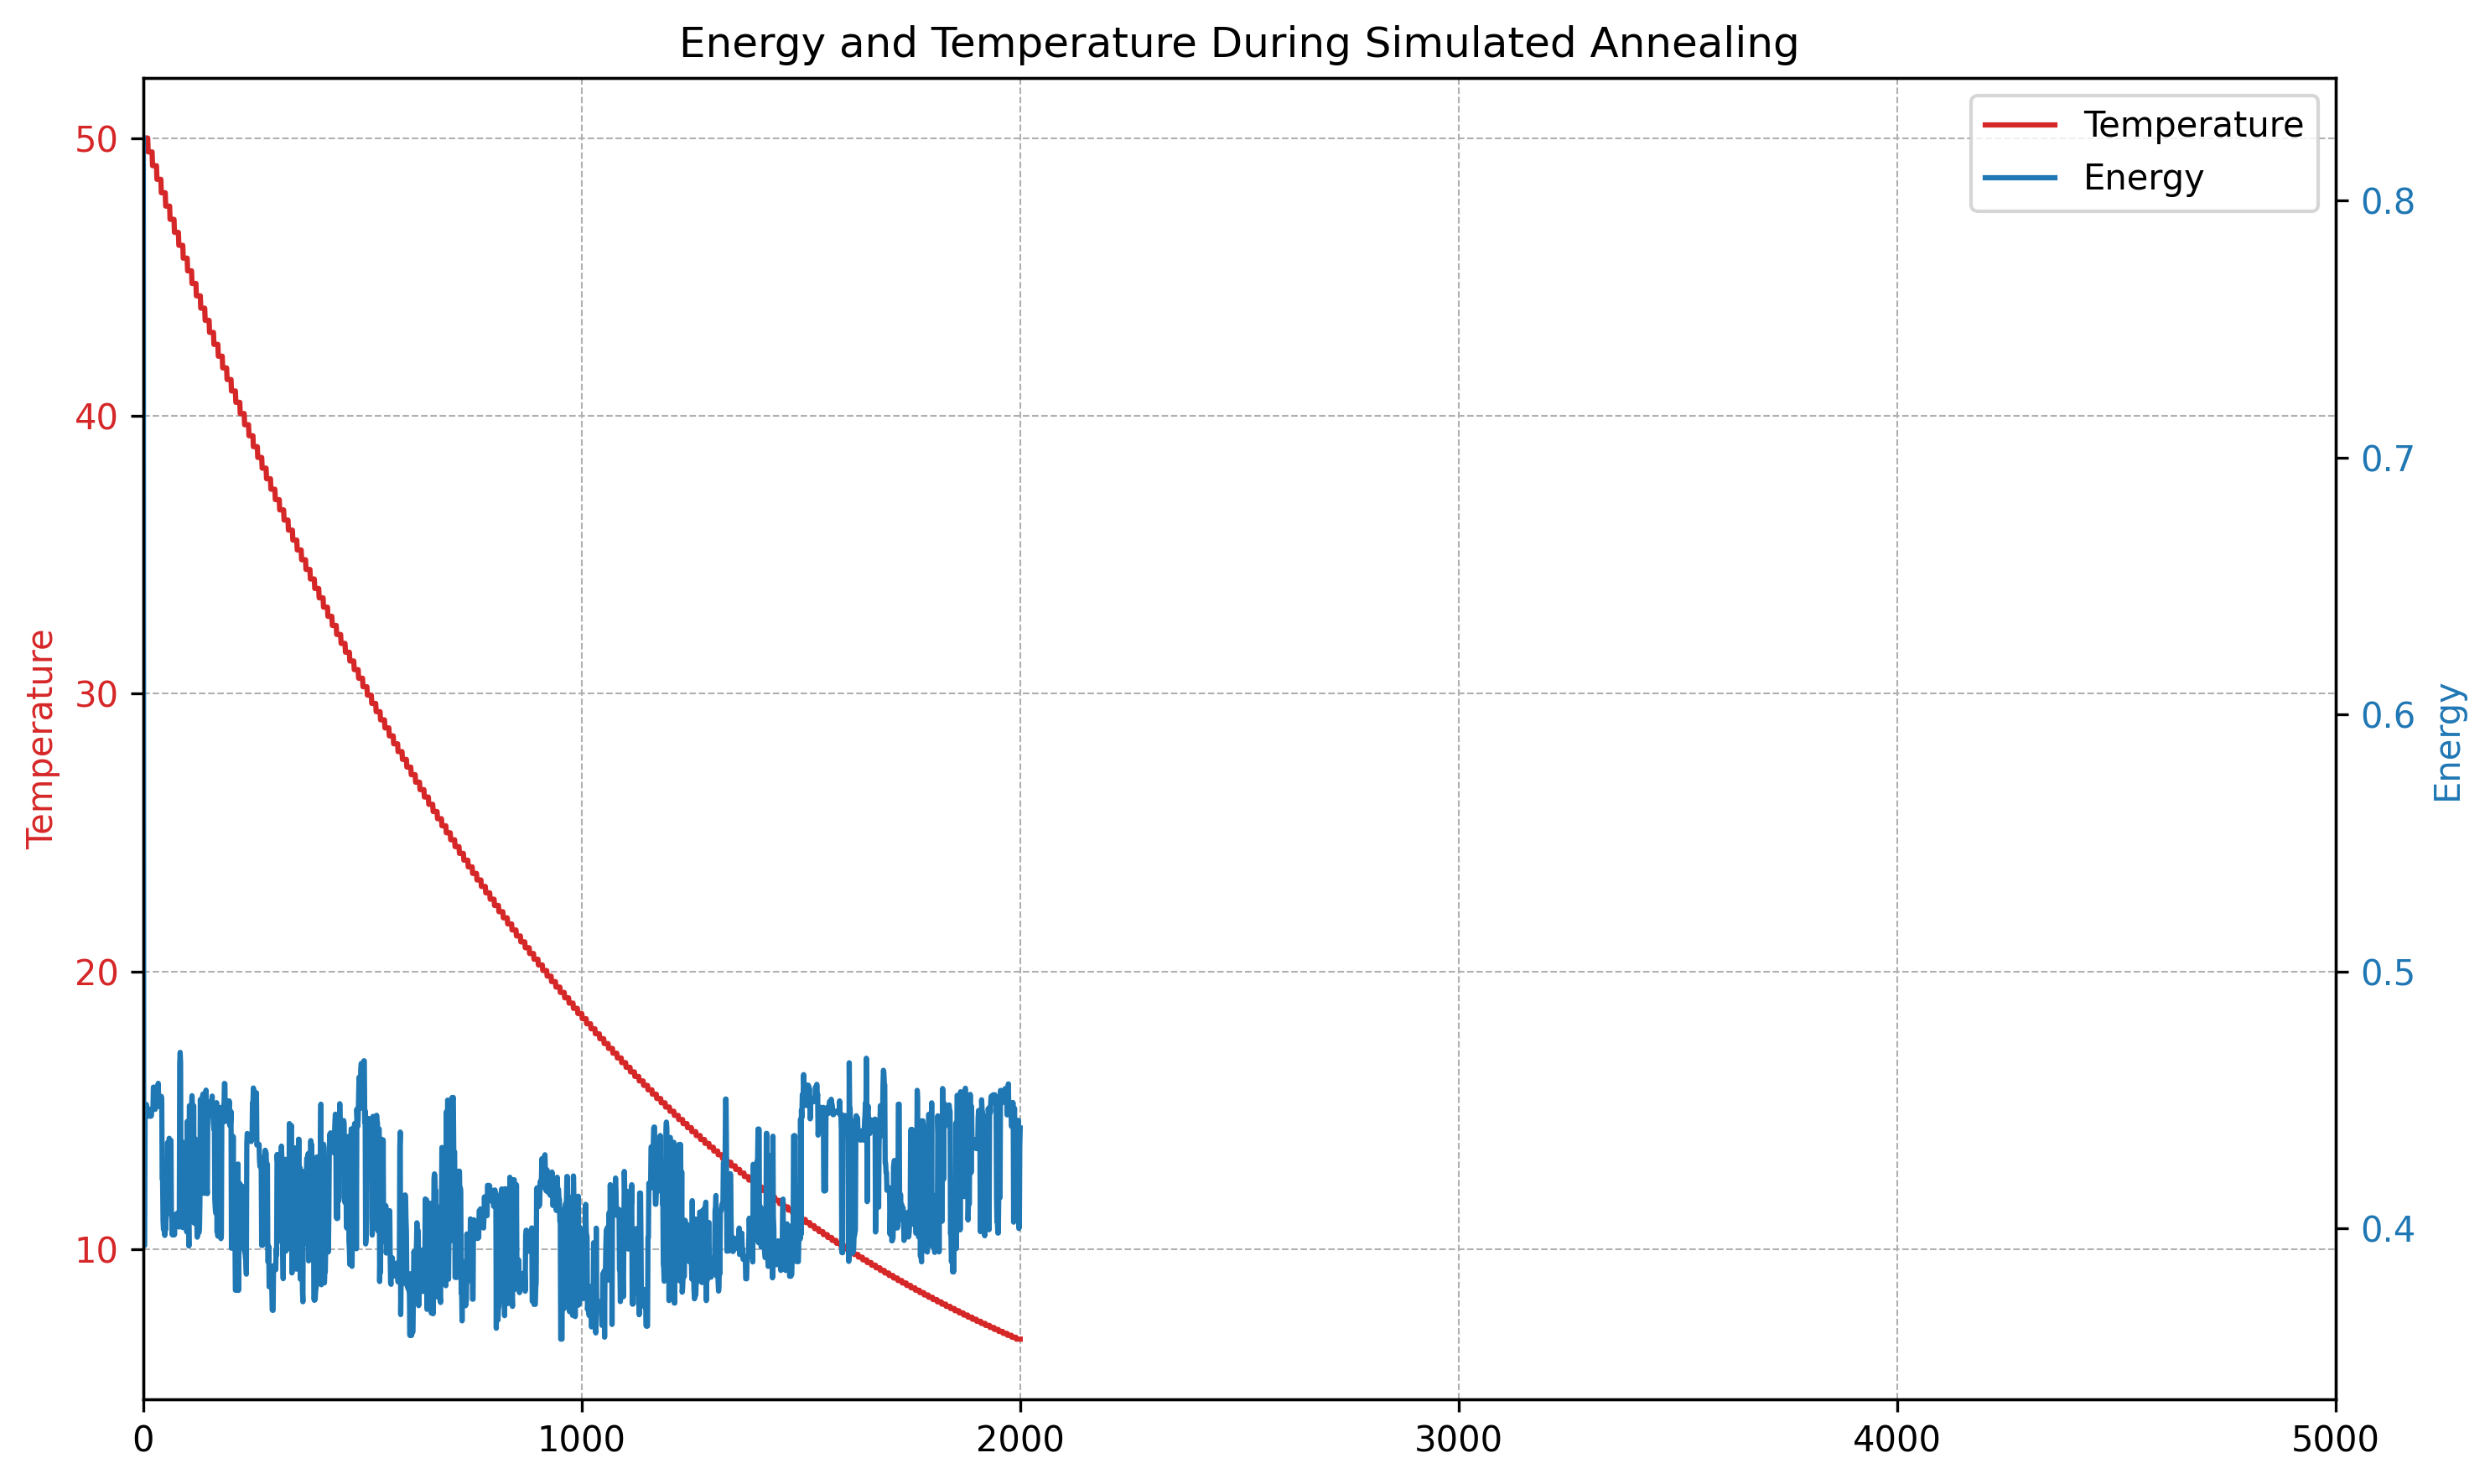

 60%|█████▉    | 299/500 [01:33<01:02,  3.22it/s]

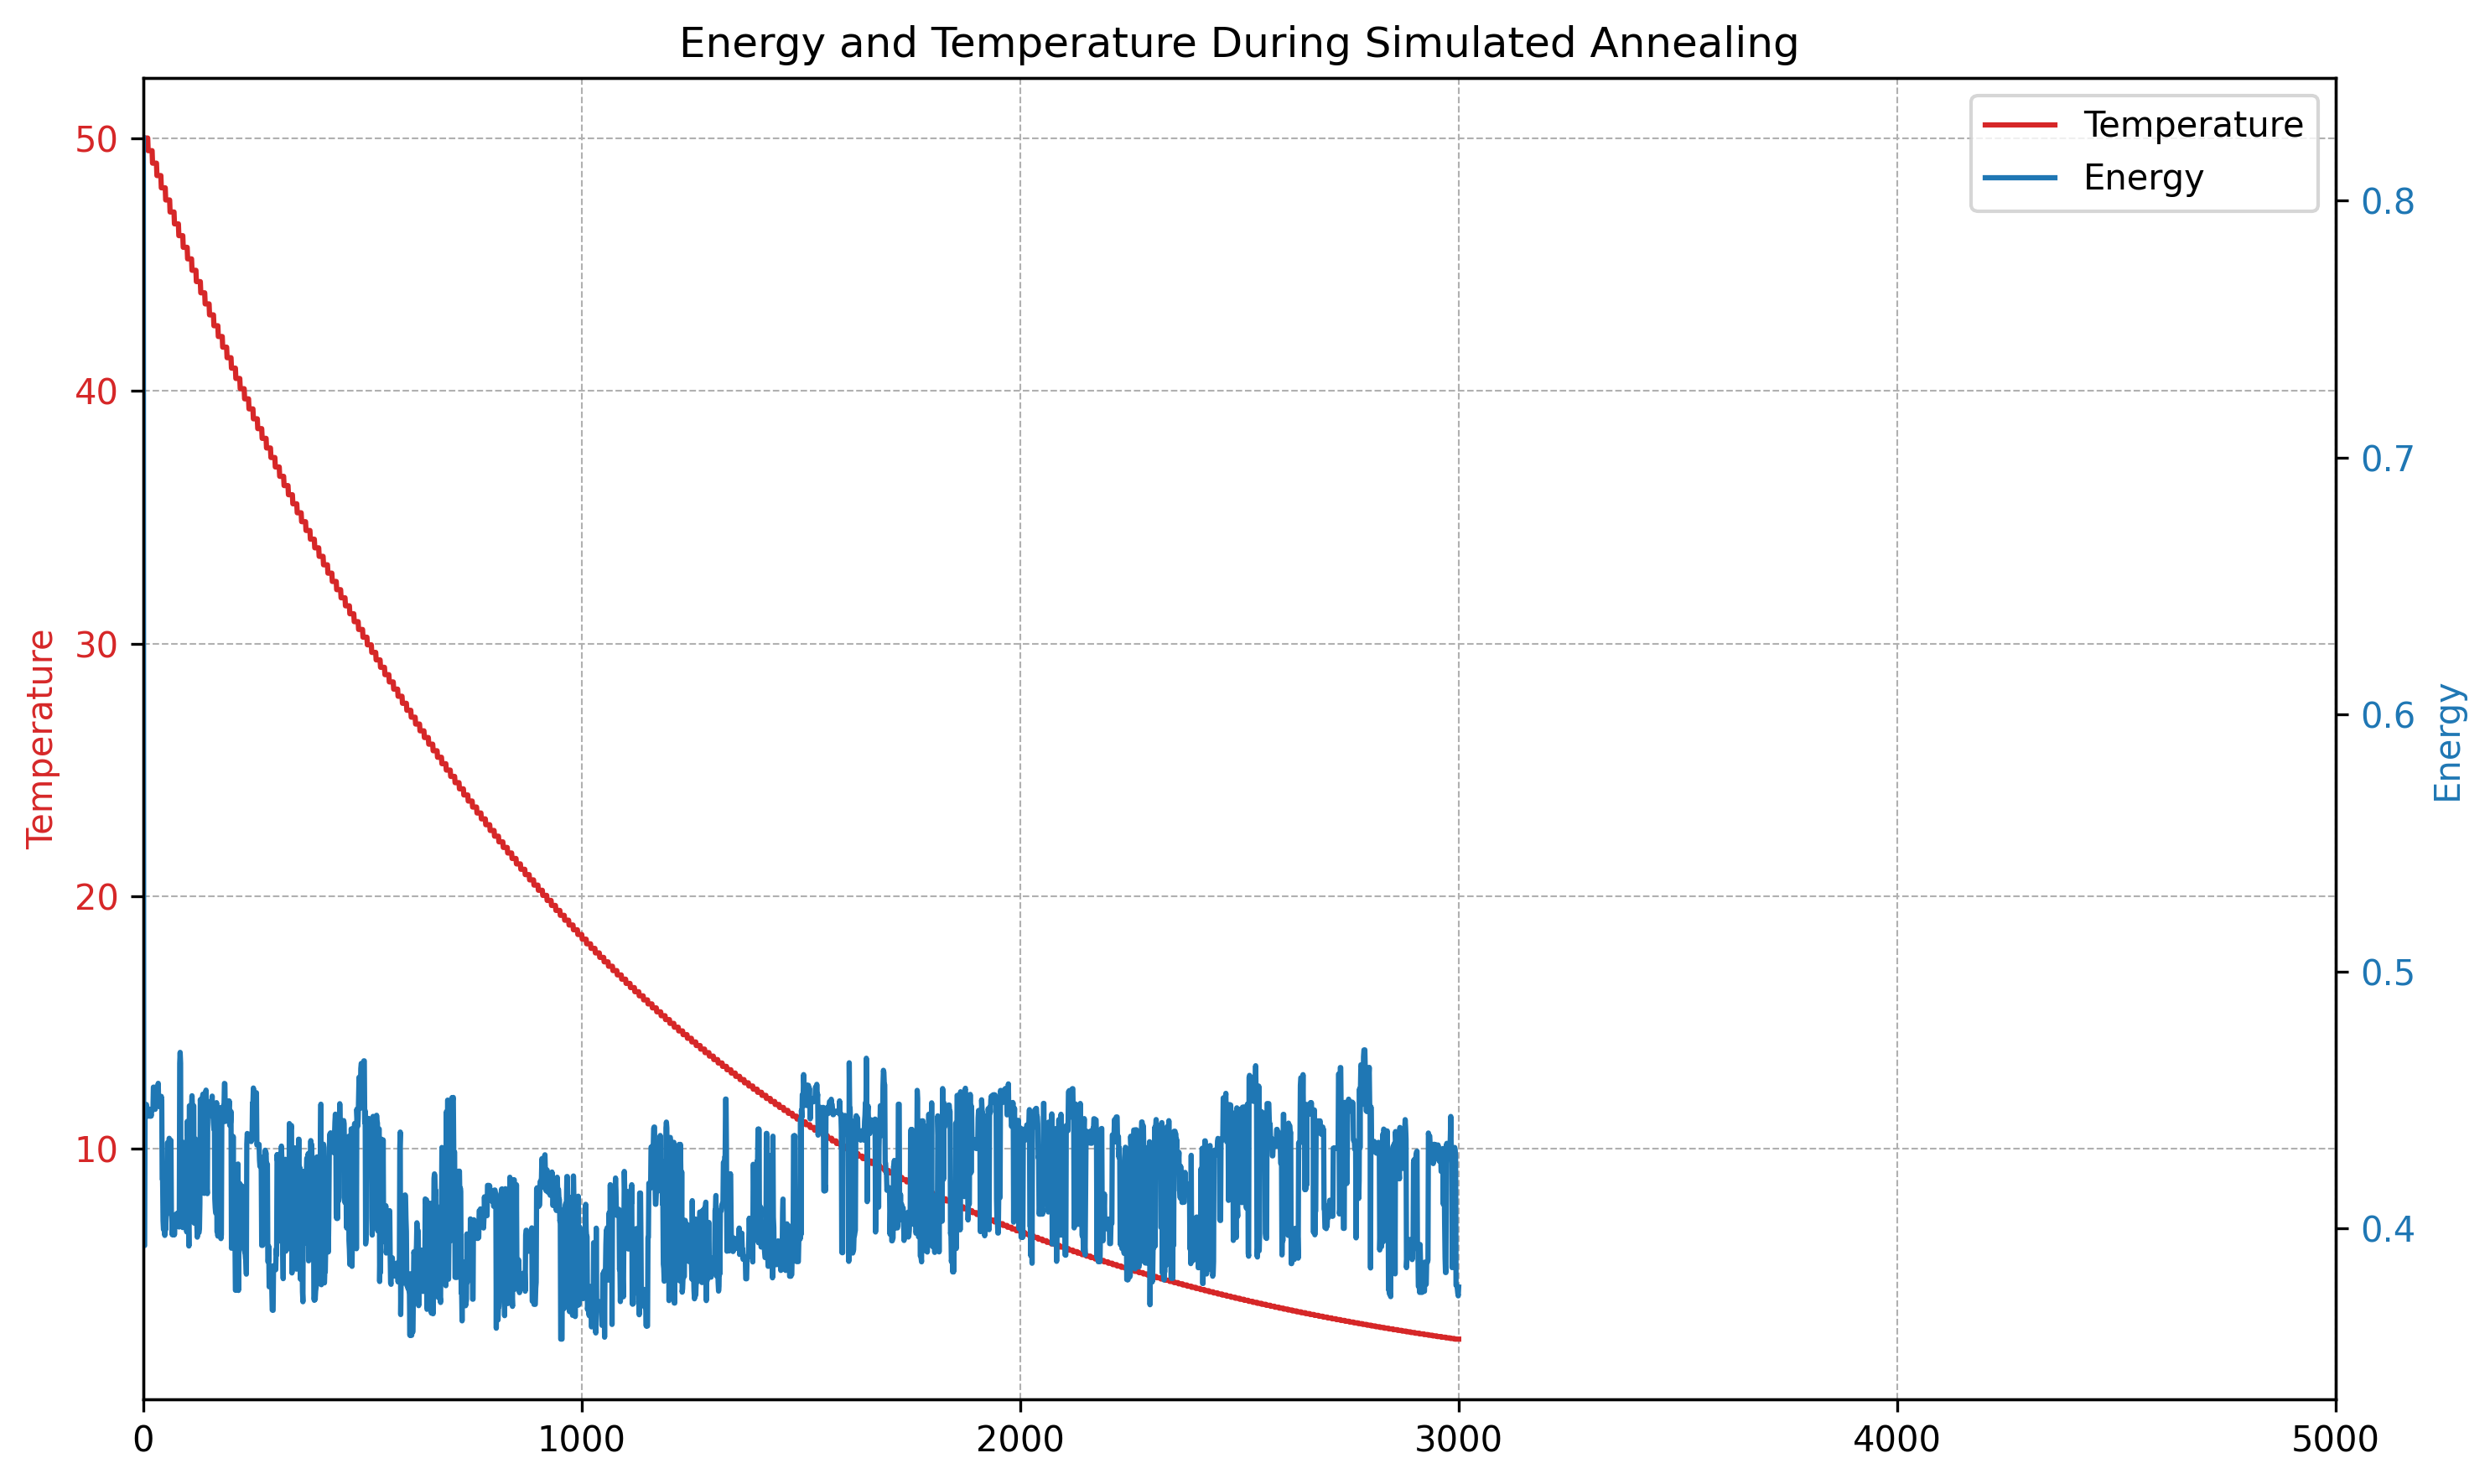

 80%|███████▉  | 399/500 [02:04<00:31,  3.21it/s]

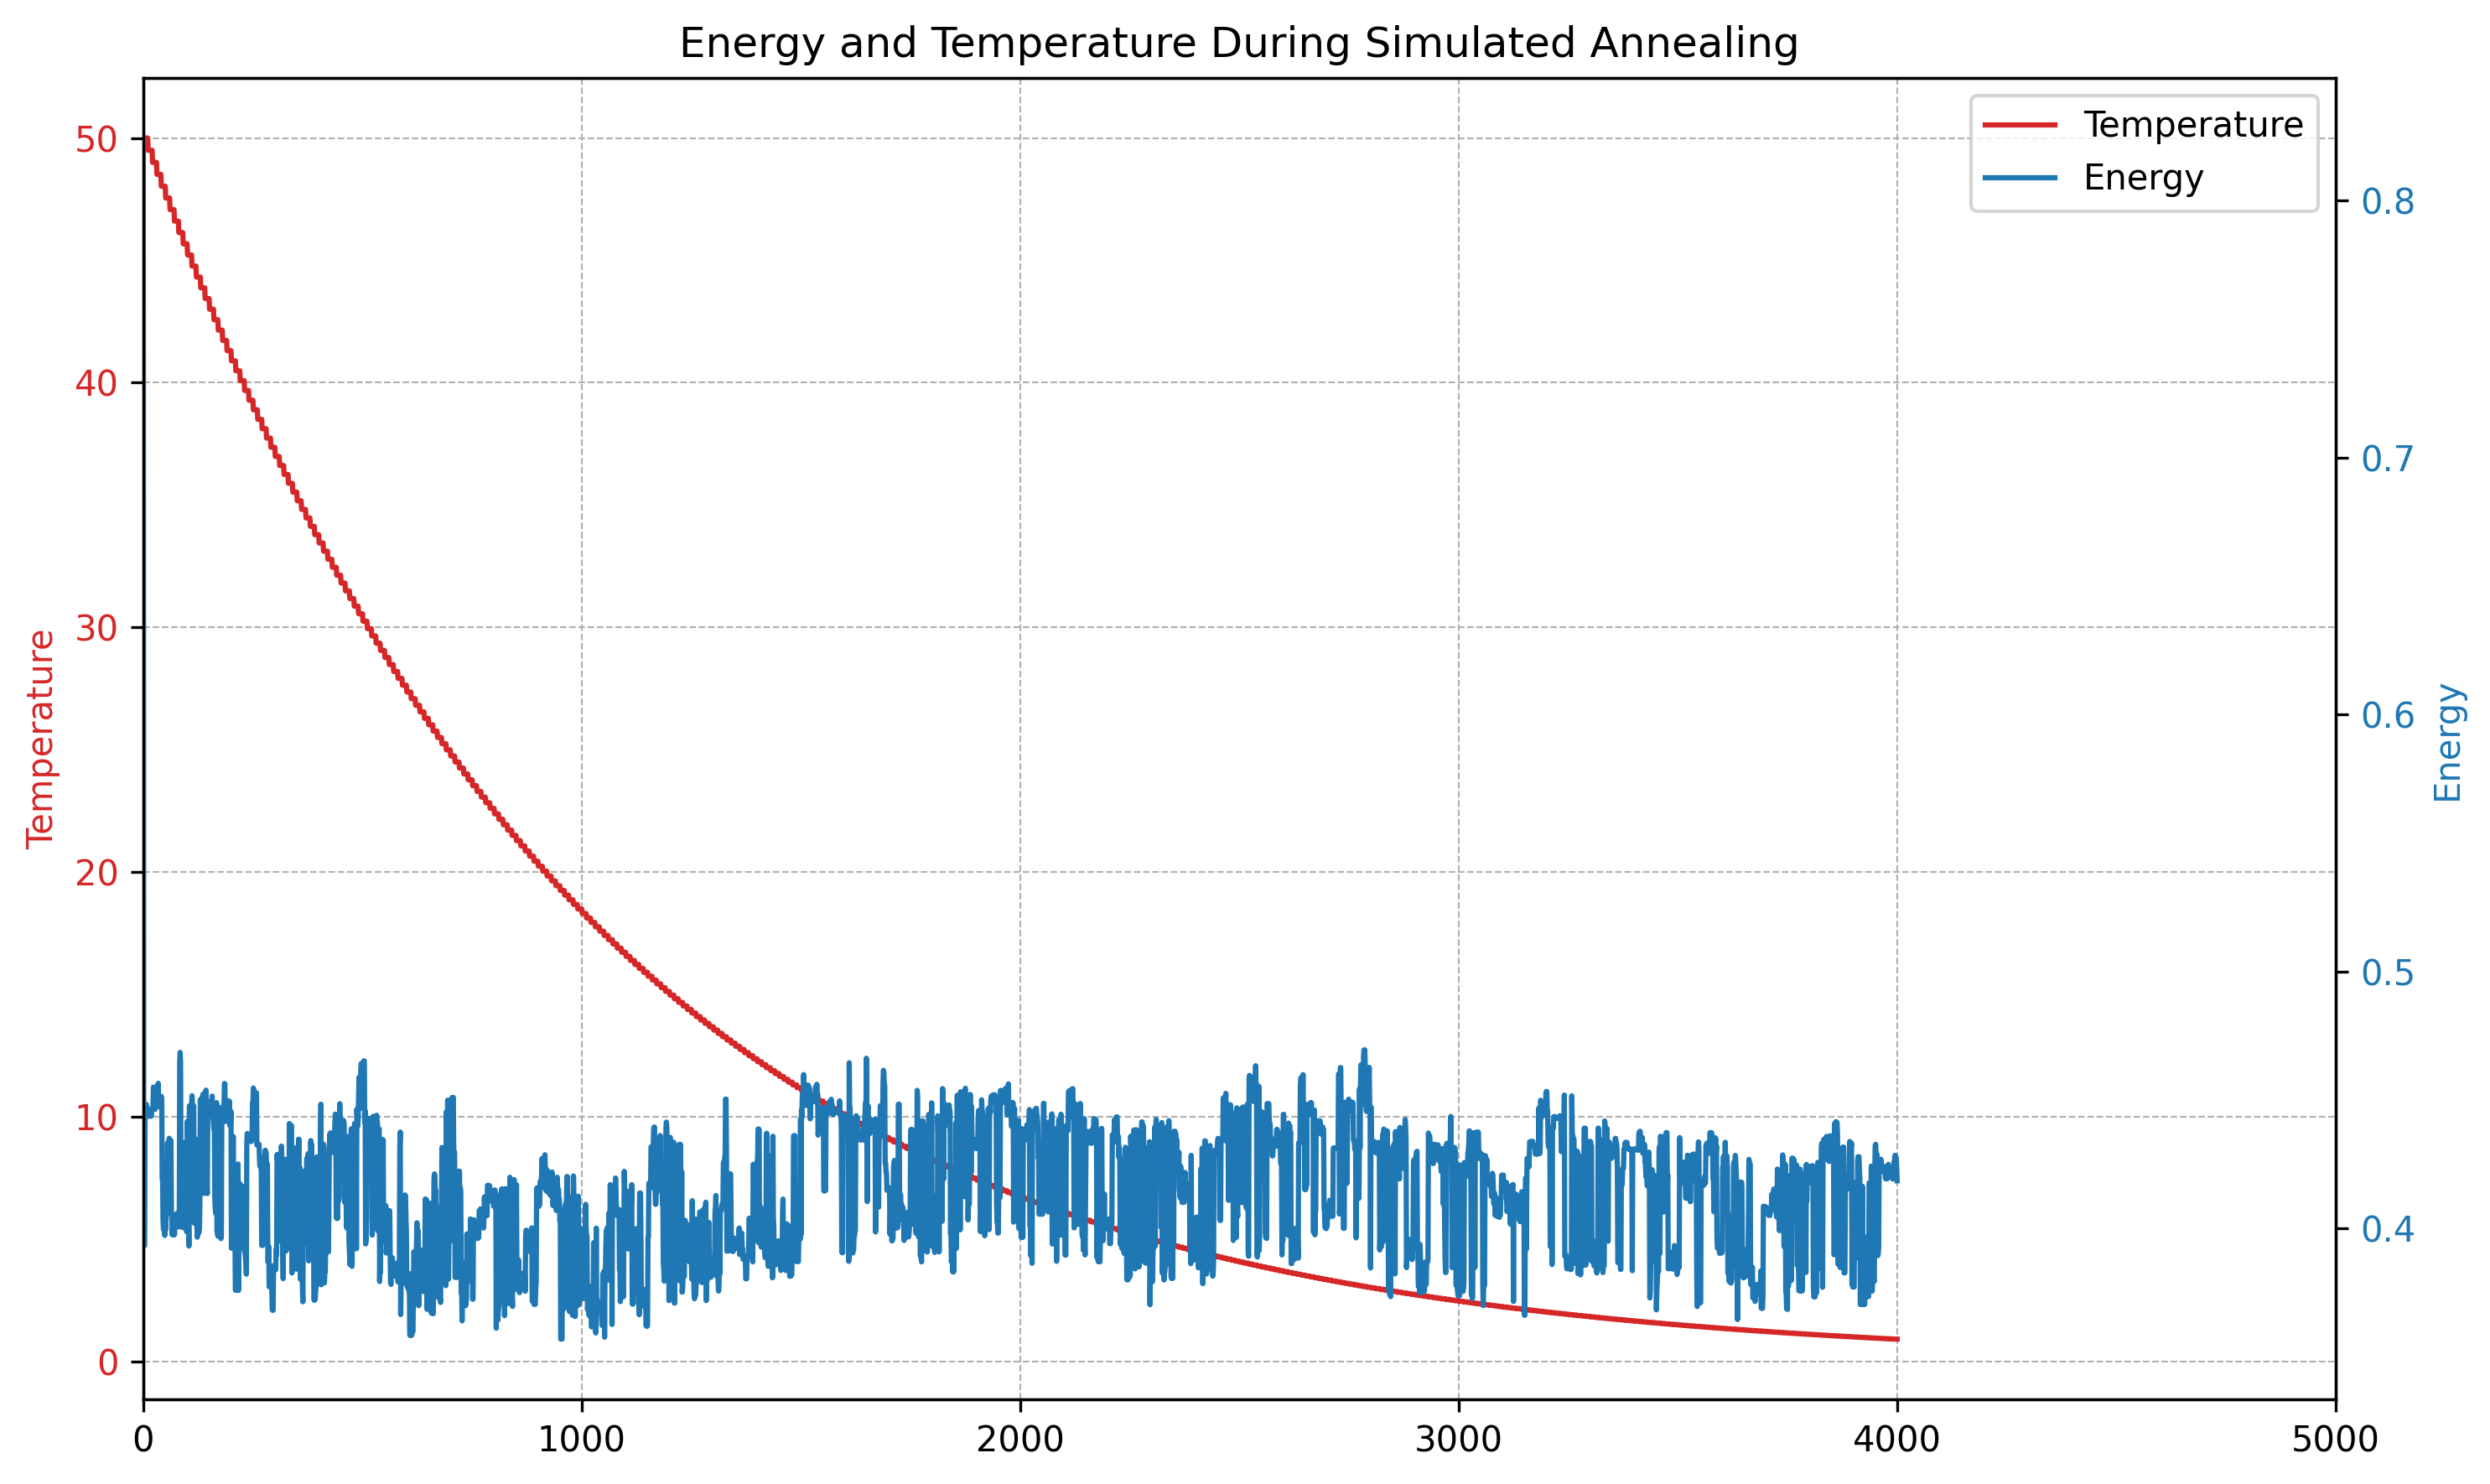

100%|█████████▉| 499/500 [02:36<00:00,  3.20it/s]

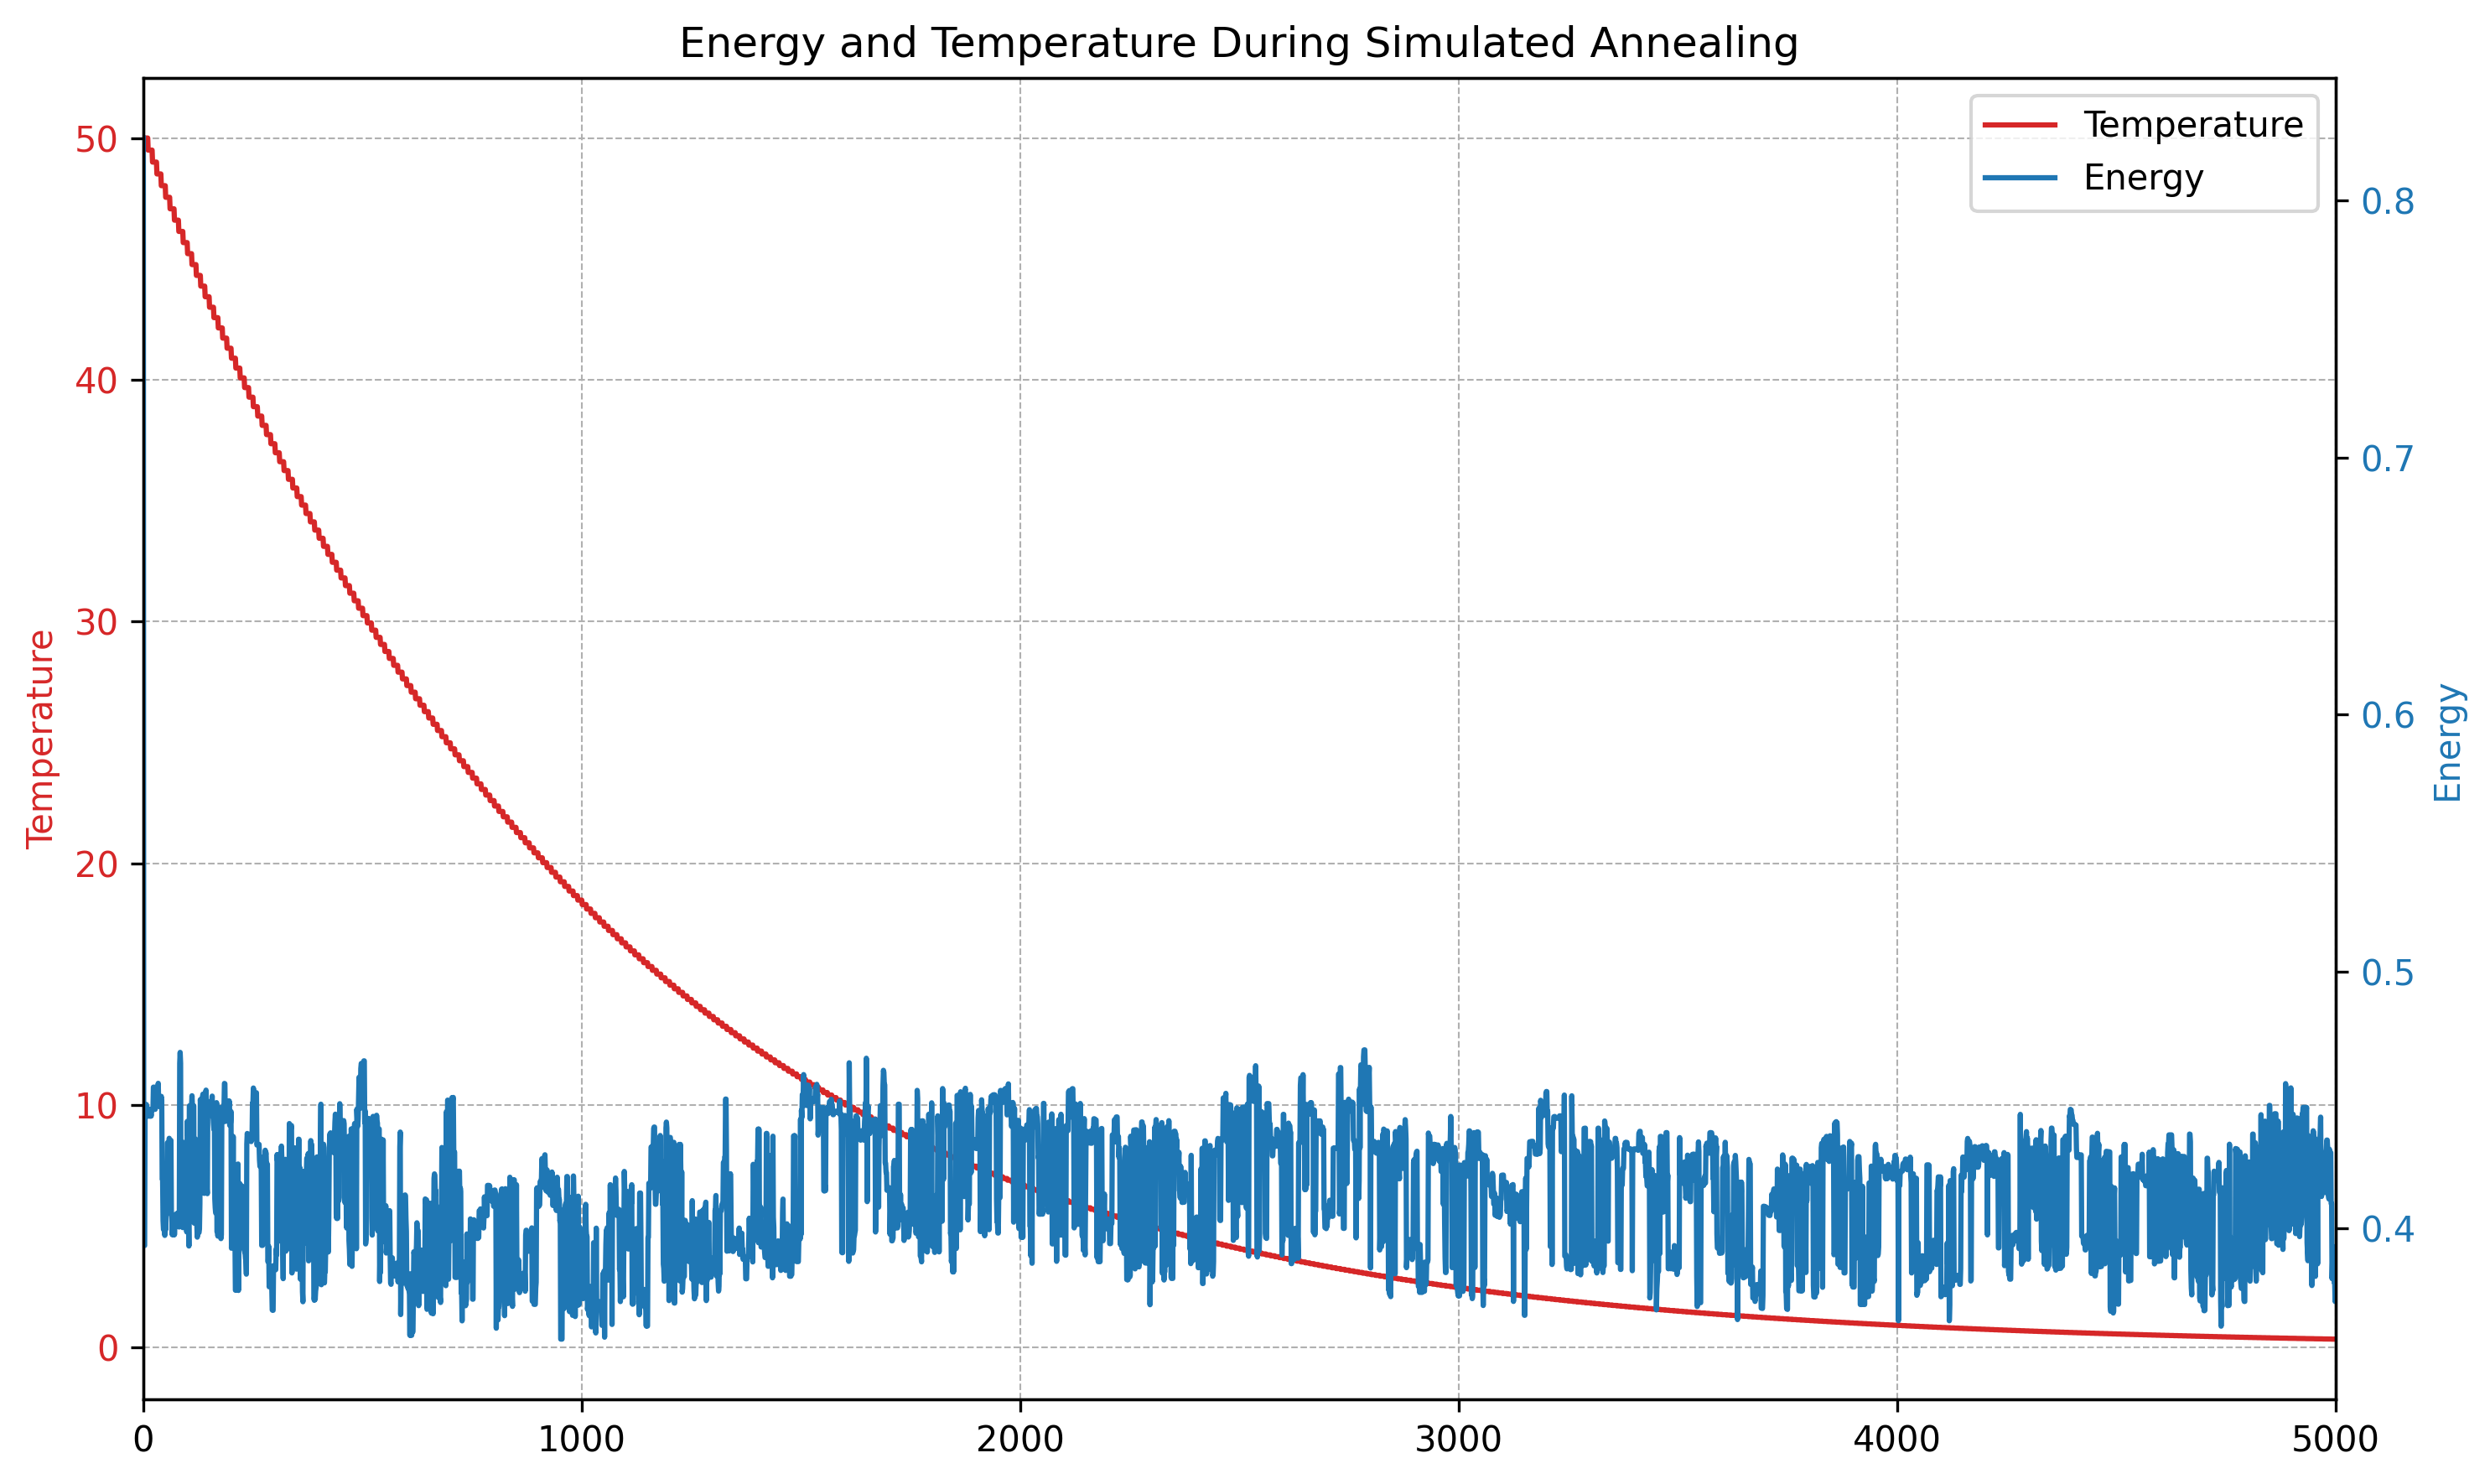

100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


In [7]:
from annealing.algorithm import AnnealingConfig, ExperimentLogger, annealing
import json

with open("../annealing/annealing_config.json", "r") as f:
    config = AnnealingConfig(**json.loads(f.read()))

logger = annealing(vertices, network, train_pressures, train_labels, test_pressures, test_labels, config)

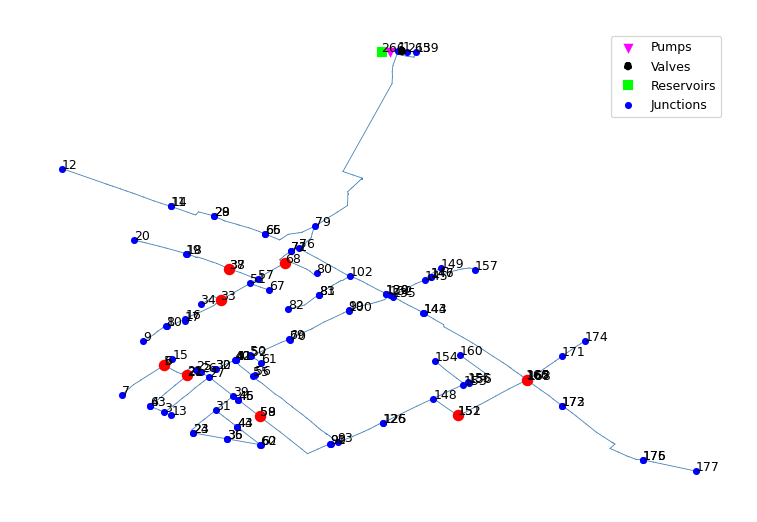

In [8]:
network.plot_with_ids(highlightnode=list(network.map_node_indexes(logger.best_solution)))